# Masters Research Project

A Comparison of Black-Box Interpretability Methods for Customer Churn Prediction using Quantitative Measures.

---

- Load and clean dataset.
- Perfrom exploratory data analysis.
- Data preprocessing.
- Model Training / Tuning and comparison (includes Random Forest, Extreme Gradient Boosting and Multilayer Perceptron).
- Model explanation using LIME, SHAP, Anchors and ELI5.

---

### Load and clean dataset

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# read dataset
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# data overview
print("Shape: ", data.shape)
print("\nFeatures: \n", data.columns)
print("\nMissing values: ", data.isnull().sum().values.sum())
print("\nUnique values: \n", data.nunique())
print("\nData info: ")
data.info()

Shape:  (7043, 21)

Features: 
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Missing values:  0

Unique values: 
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Data info:

In [3]:
# drop CustomerID as it has no contribution to prediction
data.drop('customerID', axis=1, inplace=True)

# total charges are currently object types so needs to be changed to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors="coerce")

In [4]:
# check for missing values
data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [5]:
# Drop all the rows in which value is not known
data.drop(data[data['TotalCharges'].isnull()].index, inplace=True)
data.reset_index(drop=True, inplace=True)

### Exploratory Data Analysis.

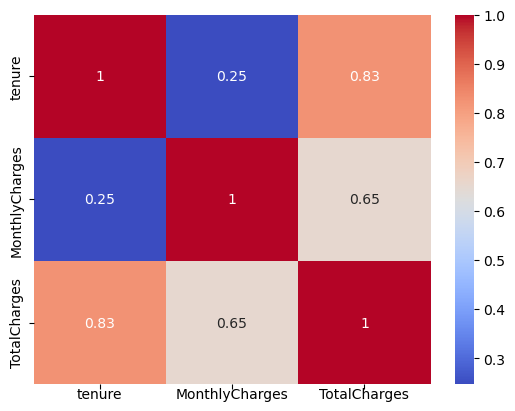

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_variables = data[['tenure', 'MonthlyCharges', 'TotalCharges']]

# correlation between numeric variables
sns.heatmap(data=numeric_variables.corr(), annot=True, cmap='coolwarm');
plt.yticks(va="center")
plt.xticks(va="center")
plt.show()

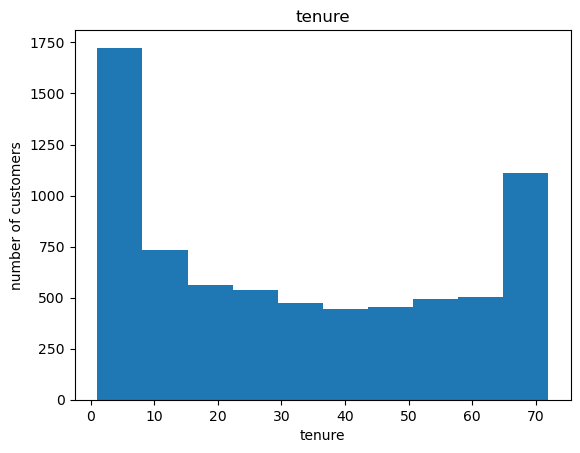

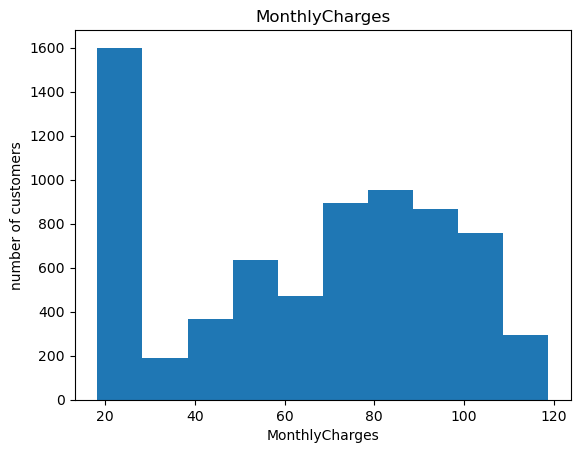

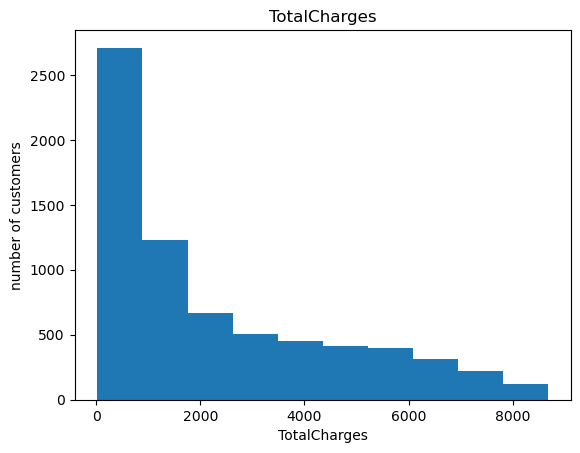

In [7]:
#distributions for all numeric variables 
for i in numeric_variables.columns:
    plt.hist(numeric_variables[i])
    plt.title(i)
    plt.ylabel('number of customers')
    plt.xlabel(i)
    plt.show()

In [8]:
# compare churn rate across numeric variables
round(pd.pivot_table(data, index='Churn', values=['tenure', 'MonthlyCharges', 'TotalCharges']), 2)

,MonthlyCharges,TotalCharges,tenure
Churn,,,
No,61.31,2555.34,37.65
Yes,74.44,1531.80,17.98


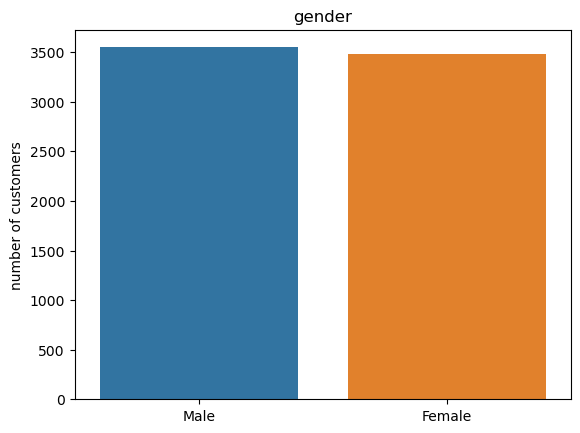

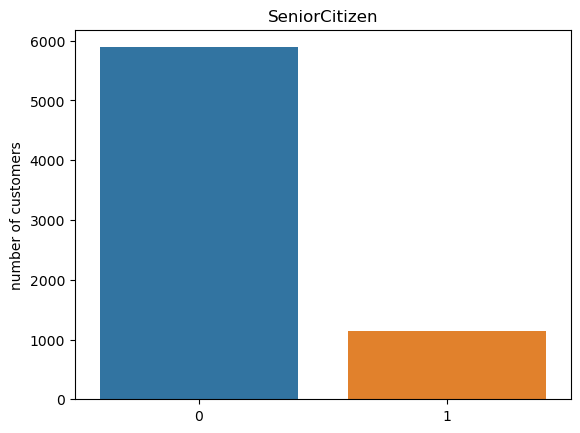

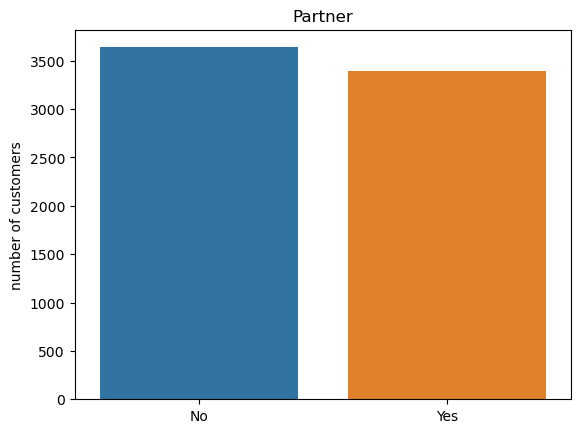

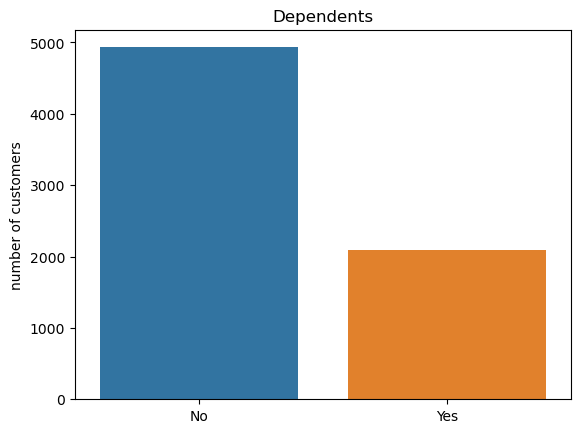

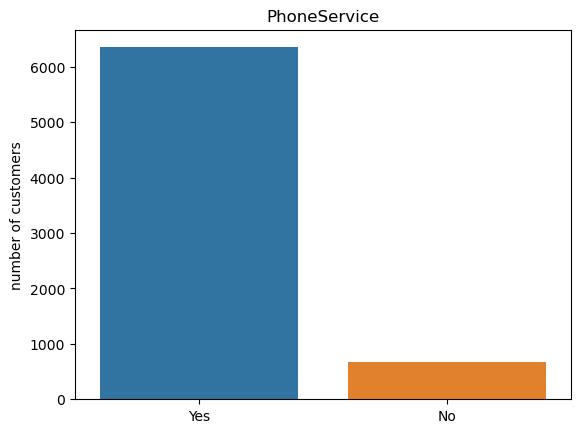

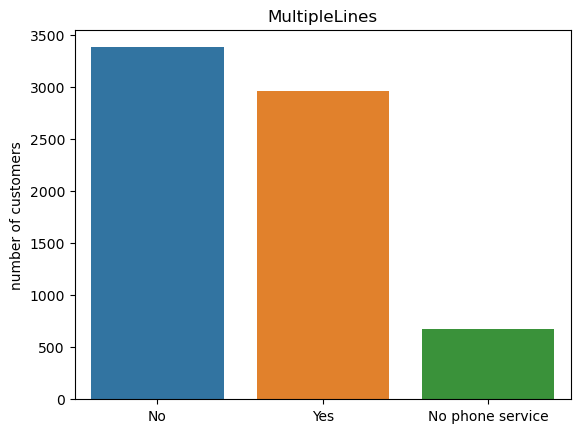

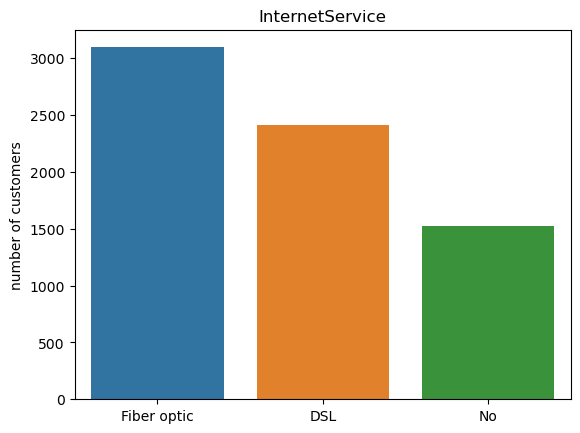

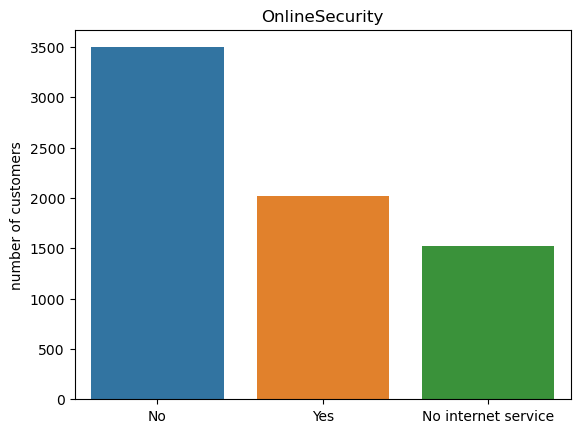

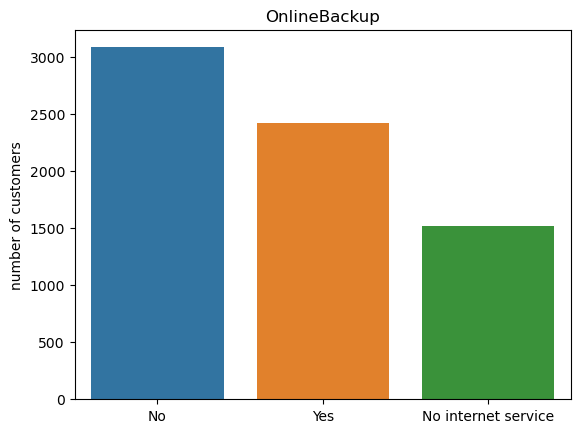

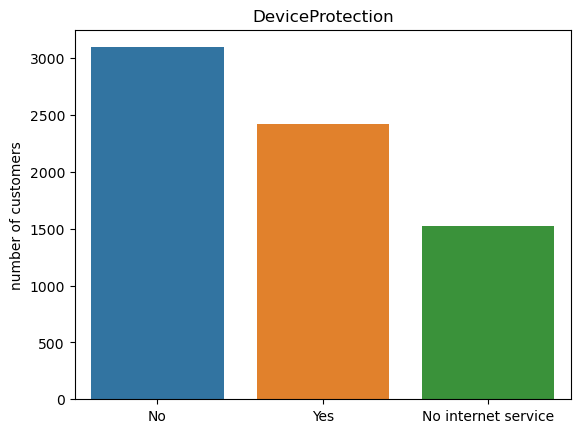

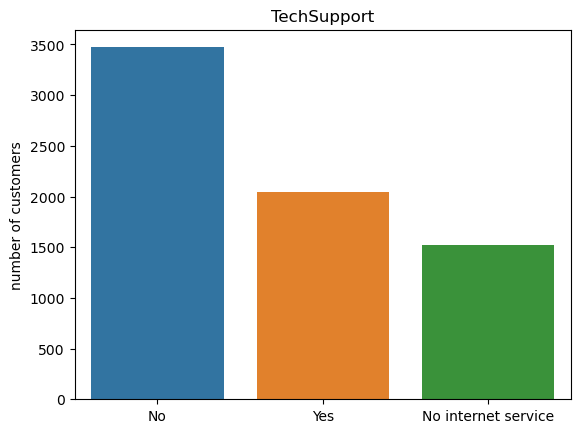

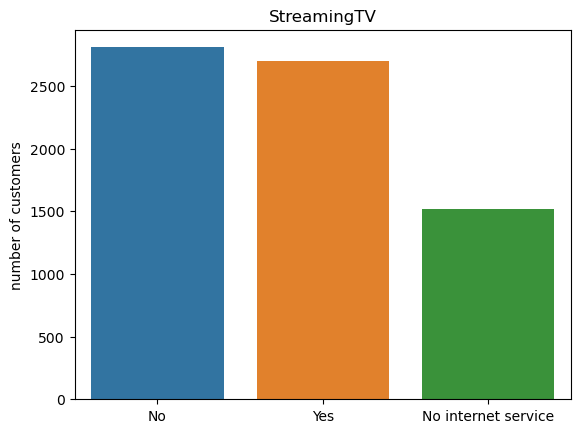

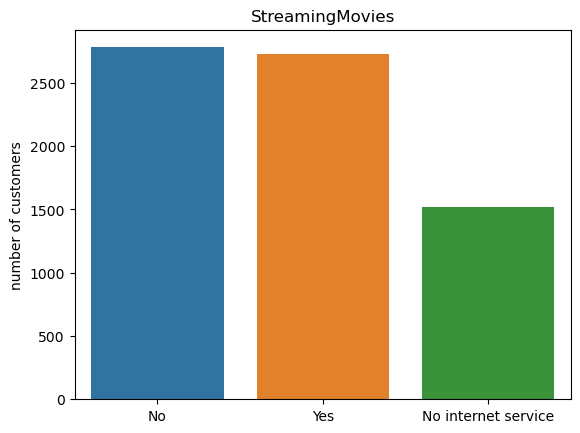

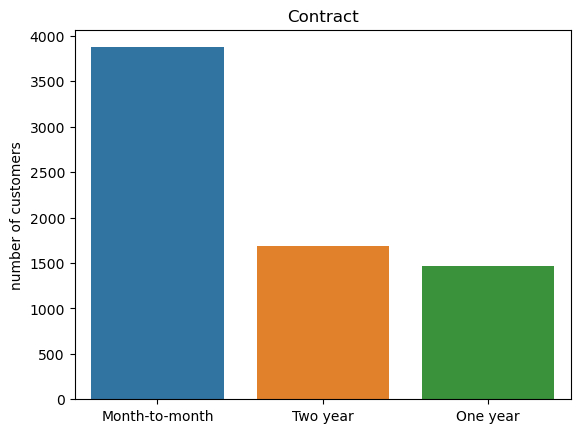

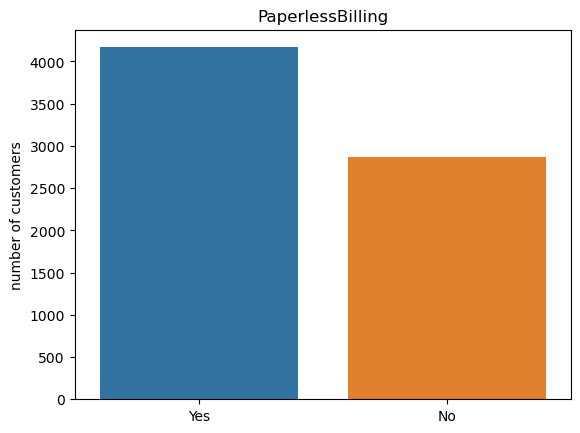

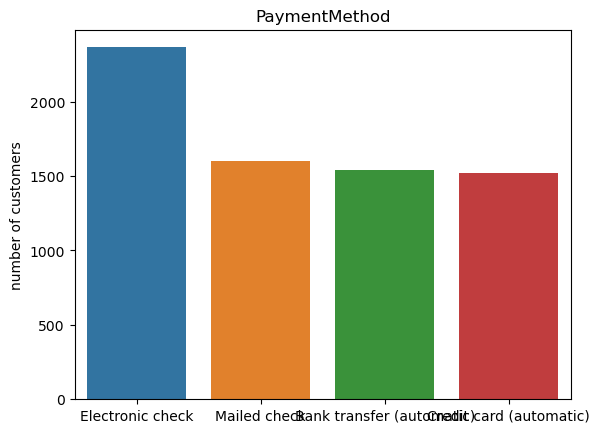

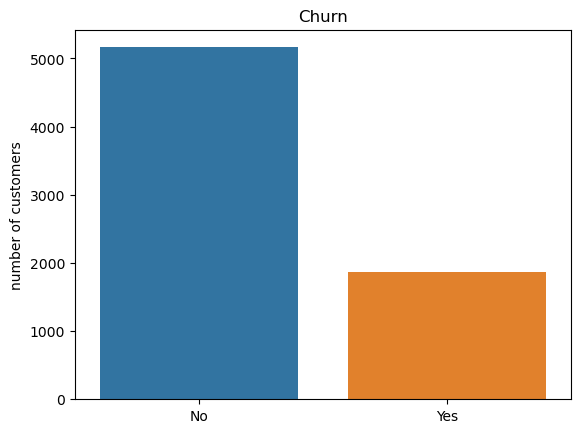

In [9]:
categorical_variables = data[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                              'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                              'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']]

# distributions for all categorical variables
for i in categorical_variables.columns:
    sns.barplot(categorical_variables[i].value_counts().index,categorical_variables[i].value_counts()).set_title(i)
    plt.ylabel('number of customers')
    plt.show()

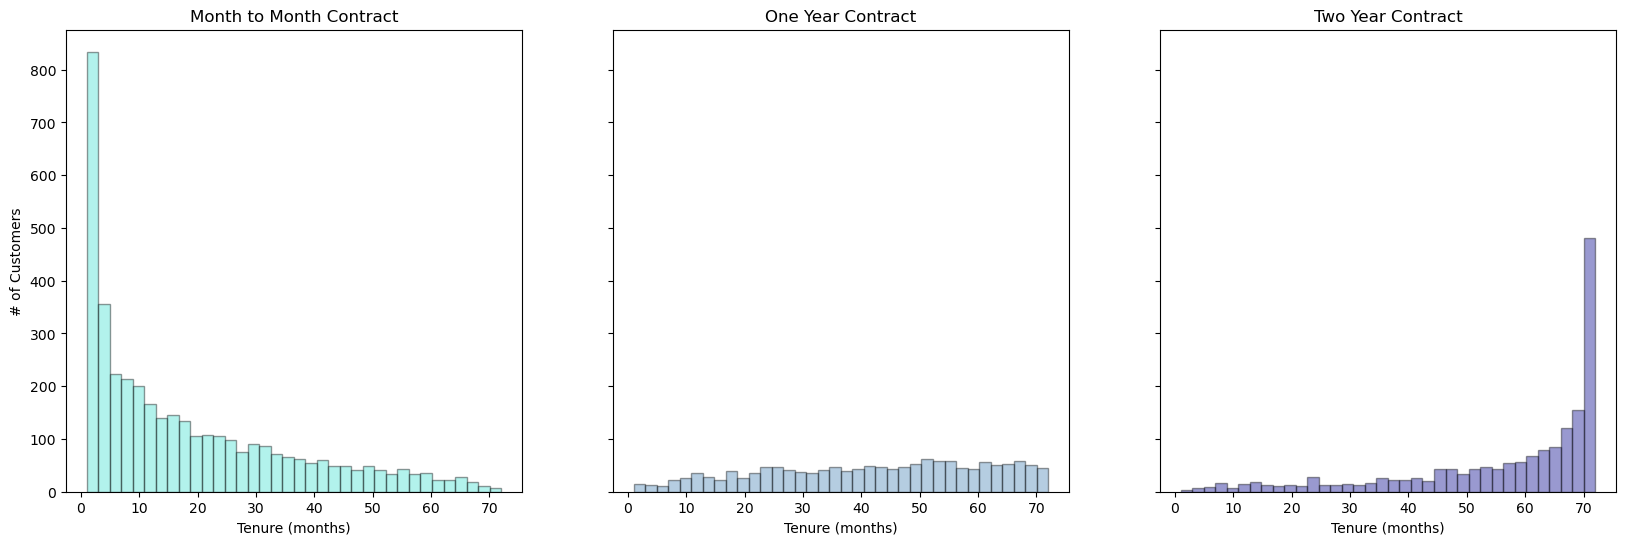

In [10]:
# tenure of customers based on their contract type
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,6))

ax1 = sns.distplot(data[data['Contract']=='Month-to-month']['tenure'],
                  hist=True, kde=False,bins=int(180/5), 
                  color = 'turquoise', hist_kws={'edgecolor':'black'},
                  kde_kws={'linewidth': 4}, ax=ax1)
ax1.set_ylabel('# of Customers')
ax1.set_xlabel('Tenure (months)')
ax1.set_title('Month to Month Contract')

ax2 = sns.distplot(data[data['Contract']=='One year']['tenure'],
                   hist=True, kde=False, bins=int(180/5), 
                   color = 'steelblue', hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4}, ax=ax2)
ax2.set_xlabel('Tenure (months)')
ax2.set_title('One Year Contract')

ax3 = sns.distplot(data[data['Contract']=='Two year']['tenure'],
                   hist=True, kde=False, bins=int(180/5), 
                   color = 'darkblue', hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4}, ax=ax3)
ax3.set_xlabel('Tenure (months)')
ax3.set_title('Two Year Contract')

plt.show()

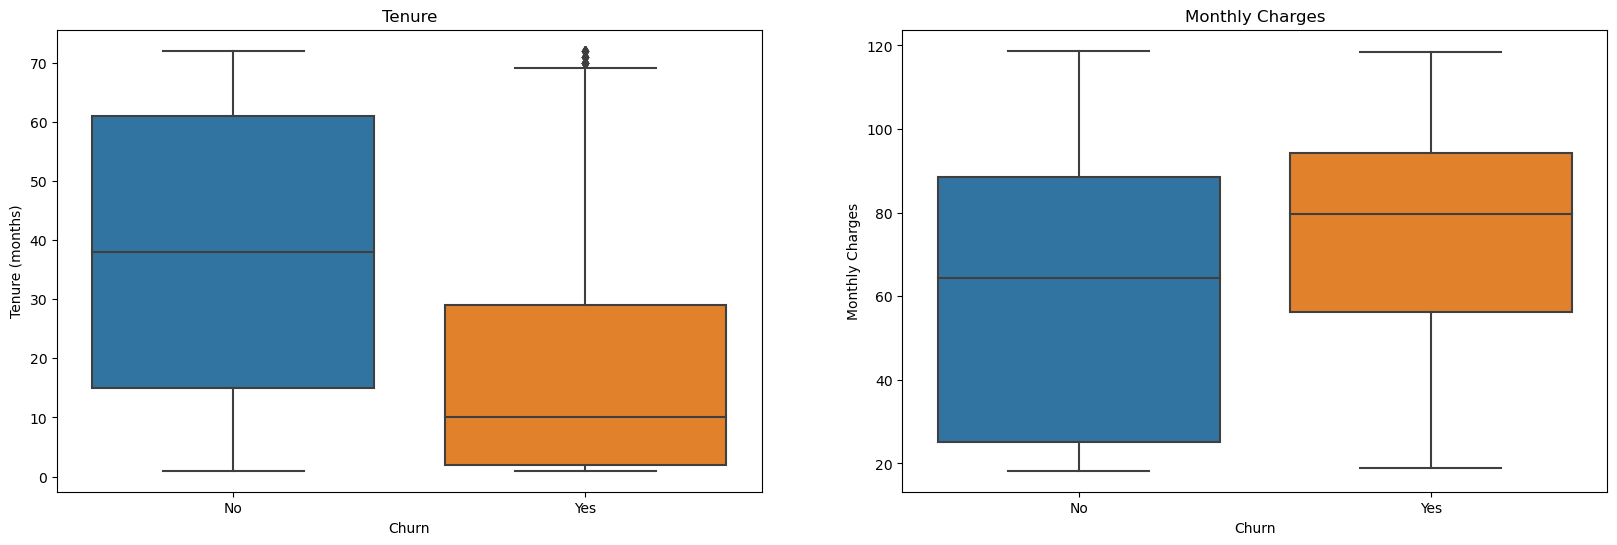

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# churn over tenure
ax1 = sns.boxplot(x=data['Churn'], y=data['tenure'], ax=ax1)
ax1.set_ylabel('Tenure (months)')
ax1.set_xlabel('Churn')
ax1.set_title('Tenure')

# churn over monthly charges
ax2 = sns.boxplot(x=data['Churn'], y=data['MonthlyCharges'], ax=ax2)
ax2.set_ylabel('Monthly Charges')
ax2.set_xlabel('Churn')
ax2.set_title('Monthly Charges')

plt.show()

In [12]:
# show list of all features with their respective categorical variables
for i in data.columns:
    if data[i].dtypes=="object":
        print(f'{i} : {data[i].unique()}')

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


### Data Preprocessing

In [13]:
# replace long negative values
data.replace('No internet service', 'No', inplace=True)
data.replace('No phone service', 'No', inplace=True)

# replace gender values
data['gender'].replace({'Female':1,'Male':0}, inplace=True)

In [14]:
# encoding for binary-class features
for i in data.columns:
    if (data[i].dtypes == "object"):
        data[i].replace({"No":0, "Yes":1}, inplace=True)
    
# one hot enconding for multi-class features
multi_class_features = []
for i in data.columns:
    if (len(data[i].unique()) > 2) & (data[i].dtypes != "int64") & (data[i].dtypes!= "float64"):
        multi_class_features.append(i)

data = pd.get_dummies(data=data, columns=multi_class_features)

In [15]:
from sklearn.preprocessing import MinMaxScaler

# feature scaling
scaler = MinMaxScaler()

continuous_values_col = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[continuous_values_col] = scaler.fit_transform(data[continuous_values_col])

In [16]:
labels = data['Churn']
data = data.drop('Churn', axis=1)

In [17]:
import sklearn.ensemble
from imblearn.over_sampling import SMOTE

# train test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data , labels, train_size=0.80, random_state=1)

# SMOTE (resampling)
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, n_jobs=None, random_state=42)
X_resample, y_resample = smote.fit_resample(X_train, y_train)

### Model Training and Tuning

In [18]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# performance reporting functions
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))


def model_performance(classifier, model_name):
    global acc, auc
    print(model_name + " classifier:")
    # calculate accuracy & roc_auc
    predicted_values = classifier.predict(X_test)
    acc = round(accuracy_score(y_test, predicted_values)*100, 2)
    auc = round(roc_auc_score(y_test, predicted_values)*100, 2)
    
    print("Accuracy : " + str(acc))
    print("ROC_AUC  : " + str(auc))
    
    # classification report
    print("\n", classification_report(y_test, predicted_values))
    
    # confusion matrix
    cm = confusion_matrix(y_test, predicted_values)
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='0.2%')
    plt.title((model_name + " Confusion Matrix"), fontsize=12)
    plt.show()
    
    return acc, auc

Random Forest (base) classifier:
Accuracy : 76.97
ROC_AUC  : 73.1

               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1041
           1       0.55      0.65      0.59       366

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.79      0.77      0.78      1407



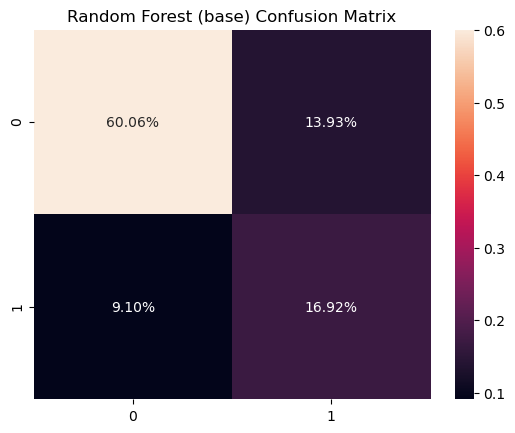

In [19]:
from sklearn.ensemble import RandomForestClassifier

# train base random forest classifier
base_rf = RandomForestClassifier(random_state=1)
base_rf.fit(X_resample, y_resample)
model_performance(base_rf, "Random Forest (base)")
acc_rf_base = acc
auc_rf_base = auc

Random Forest (tuned) classifier:
Accuracy : 78.04
ROC_AUC  : 73.29

               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1041
           1       0.57      0.63      0.60       366

    accuracy                           0.78      1407
   macro avg       0.72      0.73      0.72      1407
weighted avg       0.79      0.78      0.78      1407



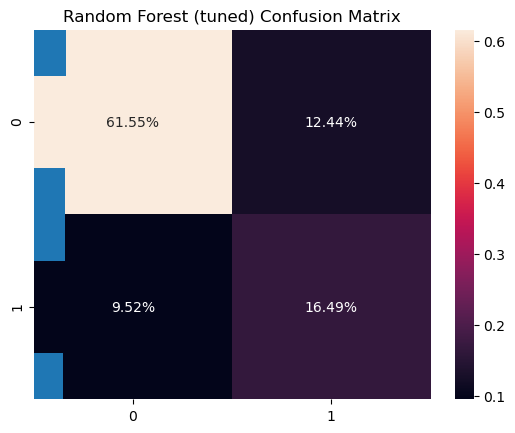

In [20]:
# model tuning to find optimum parameters for random forest classifier
"""
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [100,500,1000],
                 'bootstrap': [True,False],
                 'max_depth': [3,5,10,20,50,75,100,None],
                 'max_features': ['auto','sqrt'],
                 'min_samples_leaf': [1,2,4,10],
                 'min_samples_split': [2,5,10]}

clf_rf_rnd = RandomizedSearchCV(rf, param_distributions=rf_param_grid, n_iter=100, cv=5, verbose=True, n_jobs=-1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_resample, y_resample)
clf_performance(best_clf_rf_rnd, 'Random Forest')
"""

"""
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [50,100,150],
                 'bootstrap': [False],
                 'max_depth': [65,70,75,80,85],
                 'max_features': ['auto'],
                 'min_samples_leaf': [1,2],
                 'min_samples_split': [2,3]}

clf_rf = GridSearchCV(rf, param_grid=rf_param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_rf = clf_rf.fit(X_resample, y_resample)
clf_performance(best_clf_rf, 'Random Forest')
"""

model_rf = RandomForestClassifier(n_estimators=100, 
                                  min_samples_split=2,
                                  min_samples_leaf=1, 
                                  max_features='auto',
                                  max_depth=65, 
                                  bootstrap=False, 
                                  random_state=10)
model_rf.fit(X_resample, y_resample)
feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

# RF model performance
model_performance(model_rf, "Random Forest (tuned)")
acc_rf_tuned = acc
auc_rf_tuned = auc

[11:28:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost (base) classifier:
Accuracy : 76.76
ROC_AUC  : 73.22

               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1041
           1       0.54      0.66      0.60       366

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.79      0.77      0.77      1407



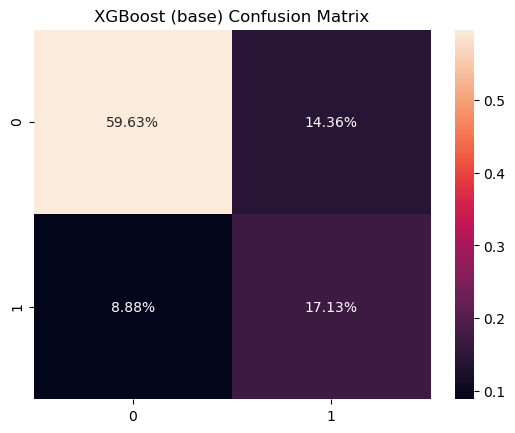

In [21]:
from xgboost import XGBClassifier

# train base XGBoost classifier
base_xgb = XGBClassifier(random_state=1)
base_xgb.fit(X_resample, y_resample)
model_performance(base_xgb, "XGBoost (base)")
acc_xgb_base = acc
auc_xgb_base = auc

[11:28:01] WARNING: ..\src\learner.cc:541: 
Parameters: { reg_lamba } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost (tuned) classifier:
Accuracy : 77.54
ROC_AUC  : 73.22

               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1041
           1       0.56      0.64      0.60       366

    accuracy                           0.78      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.79      0.78      0.78      1407



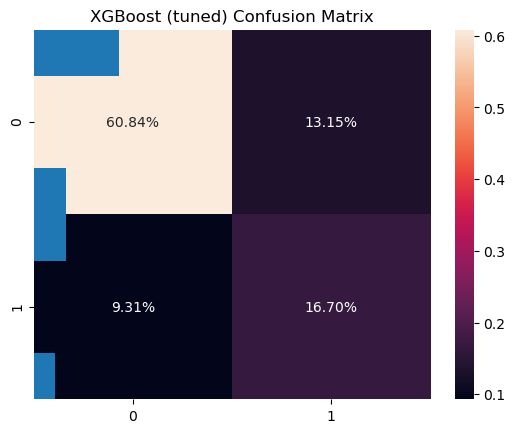

In [22]:
# model tuning to find optimum parameters for XGBoost classifier
"""
xgb = XGBClassifier(random_state=42)
param_grid = {'n_estimators': [20,50,100,250,500,1000],
              'colsample_bytree': [0.2,0.5,0.7,0.8,1],
              'max_depth': [2,5,10,15,20,25,None],
              'reg_alpha': [0,0.5,1],
              'reg_lambda': [1,1.5,2],
              'subsample': [0.5,0.6,0.7,0.8,0.9],
              'learning_rate':[.01,0.1,0.2,0.3,0.5,0.7,0.9],
              'gamma':[0,.01,.1,1,10,100],
              'min_child_weight':[0,.01,0.1,1,10,100],
              'sampling_method': ['uniform','gradient_based']}

clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=100, cv=5, verbose=True, n_jobs=-1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_resample, y_resample)
clf_performance(best_clf_xgb_rnd, 'XGB')
"""

"""
xgb = XGBClassifier(random_state=42)
param_grid = {'n_estimators': [950,1000,1050],
              'colsample_bytree': [0.6,0.7,0.8],
              'max_depth': [25,30],
              'reg_alpha': [0.5],
              'reg_lambda': [1.5],
              'subsample': [0.9,1.0],
              'learning_rate':[.01,0.1],
              'gamma':[1,2],
              'min_child_weight':[0,.01],
              'sampling_method': ['uniform']}

clf_xgb = GridSearchCV(xgb, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_xgb = clf_xgb.fit(X_resample, y_resample)
clf_performance(best_clf_xgb, 'XGB')
"""

model_xgb = XGBClassifier(n_estimators=1000, 
                          colsample_bytree=0.7,
                          max_depth=25,
                          reg_alpha=0.5,
                          reg_lamba=1.5,
                          subsample=0.9,
                          learning_rate=0.01,
                          gamma=1,
                          min_child_weight=0,
                          sampling_method='uniform',
                          eval_metric = 'auc',
                          objective = 'binary:logistic',
                          random_state=4)
model_xgb.fit(X_resample, y_resample)
feat_importances = pd.Series(model_xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

# XGB model performance
model_performance(model_xgb, "XGBoost (tuned)")
acc_xgb_tuned = acc
auc_xgb_tuned = auc

MLP (base) classifier:
Accuracy : 75.76
ROC_AUC  : 70.95

               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1041
           1       0.53      0.61      0.57       366

    accuracy                           0.76      1407
   macro avg       0.69      0.71      0.70      1407
weighted avg       0.77      0.76      0.76      1407



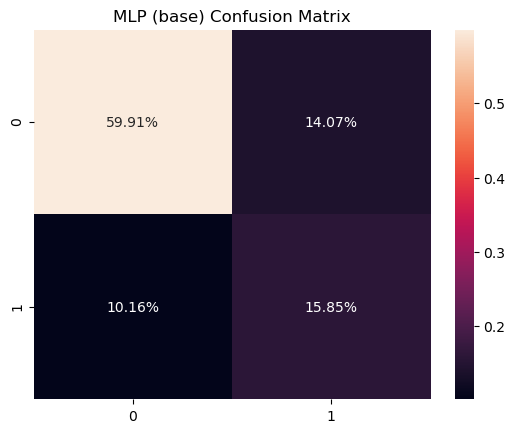

In [23]:
from sklearn.neural_network import MLPClassifier

# train base MLP classifier
base_mlp = MLPClassifier(random_state=42)
base_mlp.fit(X_resample, y_resample)
model_performance(base_mlp, "MLP (base)")
acc_mlp_base = acc
auc_mlp_base = auc

MLP (tuned) classifier:
Accuracy : 76.19
ROC_AUC  : 72.48

               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1041
           1       0.53      0.65      0.59       366

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.78      0.76      0.77      1407



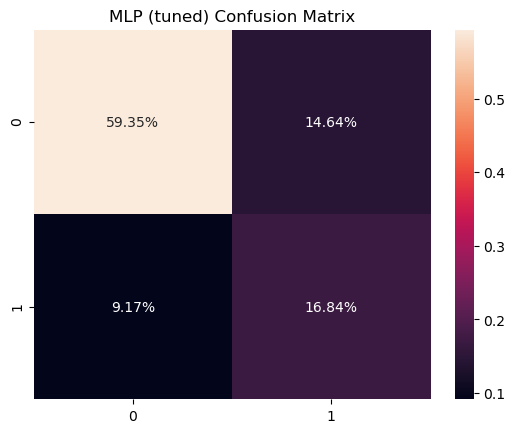

In [24]:
# model tuning to find optimum parameters for MLP classifier
"""
mlp = MLPClassifier(max_iter=100, random_state=42)
param_grid = {'batch_size' : [10, 20, 40, 60, 80, 100],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive'],}

clf_mlp = GridSearchCV(mlp, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_mlp = clf_mlp.fit(X_resample, y_resample)
clf_performance(best_clf_mlp, 'MLP')
"""

model_mlp = MLPClassifier(activation='relu',
                          batch_size=40,
                          solver='adam', 
                          max_iter=100, 
                          alpha=0.0001,
                          learning_rate='constant',
                          random_state=42)
model_mlp.fit(X_resample, y_resample)

# MLP model performance
model_performance(model_mlp, "MLP (tuned)")
acc_mlp_tuned = acc
auc_mlp_tuned = auc

In [25]:
# model comparison
models = pd.DataFrame({
    'Model':['RF', 'XGB', 'MLP'],
    'Accuracy_base' :[acc_rf_base, acc_xgb_base, acc_mlp_base],
    'Accuracy_tuned' :[acc_rf_tuned, acc_xgb_tuned, acc_mlp_tuned],
    'ROC_AUC_base' :[auc_rf_base, auc_xgb_base, auc_mlp_base],
    'ROC_AUC_tuned' :[auc_rf_tuned, auc_xgb_tuned, auc_mlp_tuned]
})
models

,Model,Accuracy_base,Accuracy_tuned,ROC_AUC_base,ROC_AUC_tuned
0,RF,76.97,78.04,73.10,73.29
1,XGB,76.76,77.54,73.22,73.22
2,MLP,75.76,76.19,70.95,72.48


In [26]:
# change variable name for best classifier
model = model_rf

In [27]:
# misclassified points
np.where(y_test!=model.predict(X_test.values))[0]

array([   3,   11,   14,   24,   25,   29,   32,   39,   44,   45,   47,
         49,   52,   58,   62,   66,   76,   93,   98,   99,  102,  104,
        113,  114,  119,  128,  130,  131,  132,  140,  142,  144,  149,
        153,  159,  163,  165,  167,  168,  171,  173,  176,  179,  192,
        194,  203,  207,  209,  212,  227,  230,  231,  242,  245,  247,
        248,  251,  253,  255,  260,  265,  268,  278,  279,  281,  293,
        295,  297,  301,  314,  315,  316,  317,  318,  321,  325,  330,
        331,  335,  338,  340,  341,  343,  350,  351,  355,  357,  358,
        365,  367,  372,  373,  378,  381,  383,  384,  390,  396,  410,
        416,  417,  430,  433,  434,  450,  458,  462,  470,  480,  484,
        485,  495,  509,  513,  521,  525,  526,  527,  528,  538,  539,
        541,  544,  545,  553,  554,  555,  559,  562,  567,  569,  570,
        577,  585,  586,  589,  602,  617,  620,  624,  631,  632,  633,
        634,  656,  657,  662,  669,  670,  674,  6

In [28]:
# data instance
idx = 0

# convert data instance into readable format for participant
print('True Class: %s' % y_test.iloc[idx])
print('Prediction: %d' % model.predict(X_test.values[idx].reshape(1,-1))[0])
data_instance = pd.DataFrame(X_test.iloc[idx]).T

data_instance[continuous_values_col] = scaler.inverse_transform(data_instance[continuous_values_col])

data_instance['gender'].replace({1:"Female",0:"Male"}, inplace=True)

binary_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                  'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 
                  'StreamingMovies', 'PaperlessBilling', 'InternetService_0', 
                  'InternetService_DSL', 'InternetService_Fiber optic', 
                  'Contract_Month-to-month', 'Contract_One year', 
                  'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
                  'PaymentMethod_Credit card (automatic)',
                  'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

for i in binary_columns:
    data_instance[i].replace({0:"No",1:"Yes"}, inplace=True)

data_instance['tenure'] = data_instance['tenure'].astype(int)
data_instance.T

True Class: 0
Prediction: 0


,1773
gender,Male
SeniorCitizen,No
Partner,Yes
Dependents,Yes
tenure,72
PhoneService,Yes
MultipleLines,Yes
OnlineSecurity,No
OnlineBackup,No
DeviceProtection,No


### Model Explanations

In [29]:
import lime
from lime import lime_tabular

# initialise LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    np.array(X_resample), class_names= ['Non-Churn','Churn'], feature_names= data.columns.values, 
    categorical_features= range(data.shape[1]-2), 
    kernel_width=3, verbose=False)

In [30]:
# explain instance using LIME explainer
lime_exp = lime_explainer.explain_instance(X_test.iloc[idx],  
                                 predict_fn=model.predict_proba, num_features=5, 
                                 top_labels=1)

print('Document id: %d' % idx)
print('Probability(0) =',model.predict_proba(X_test.values[idx].reshape(1,-1))[0,0])
print('Probability(1) =',model.predict_proba(X_test.values[idx].reshape(1,-1))[0,1])
print('True class: %s' % y_test.iloc[idx])

lime_exp.show_in_notebook(show_table=True, show_all=False)

Document id: 0
Probability(0) = 1.0
Probability(1) = 0.0
True class: 0


  0%|          | 0/1407 [00:00<?, ?it/s]

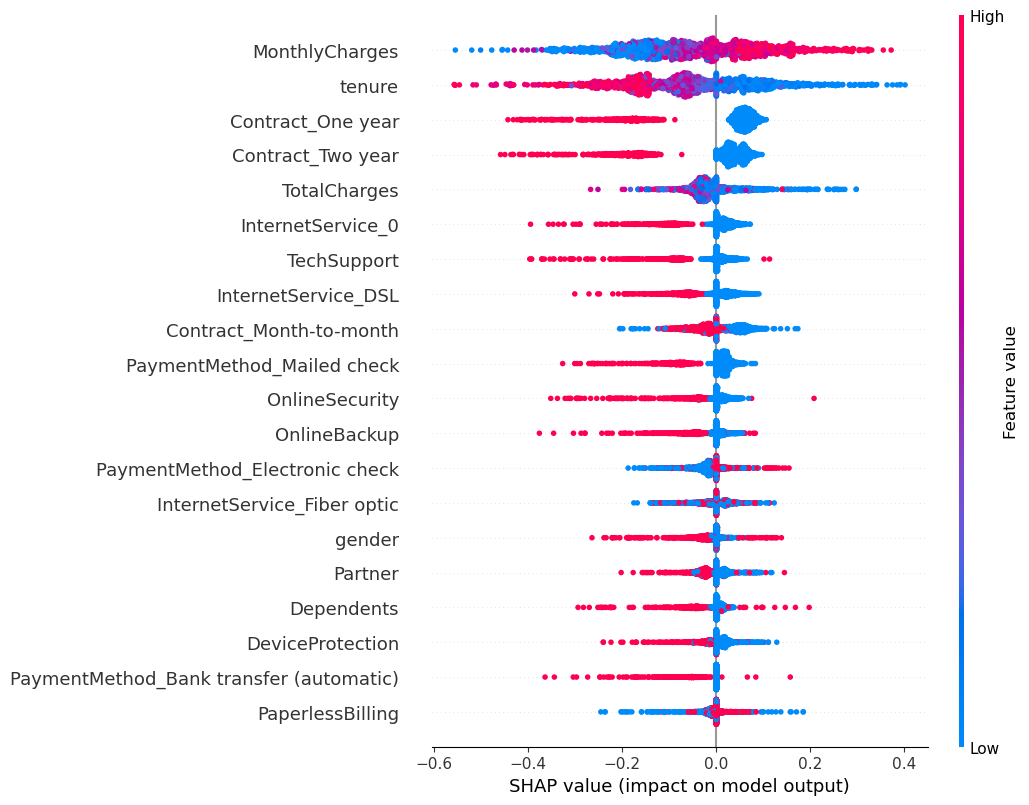

In [31]:
import shap
shap.initjs()

X_train_summary = shap.kmeans(X_resample, 10)

# initialise SHAP explainer and explain all the predictions in the test set
shap_explainer = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = shap_explainer.shap_values(X_test)

# SHAP global interpretation
shap.summary_plot(shap_values, X_test)

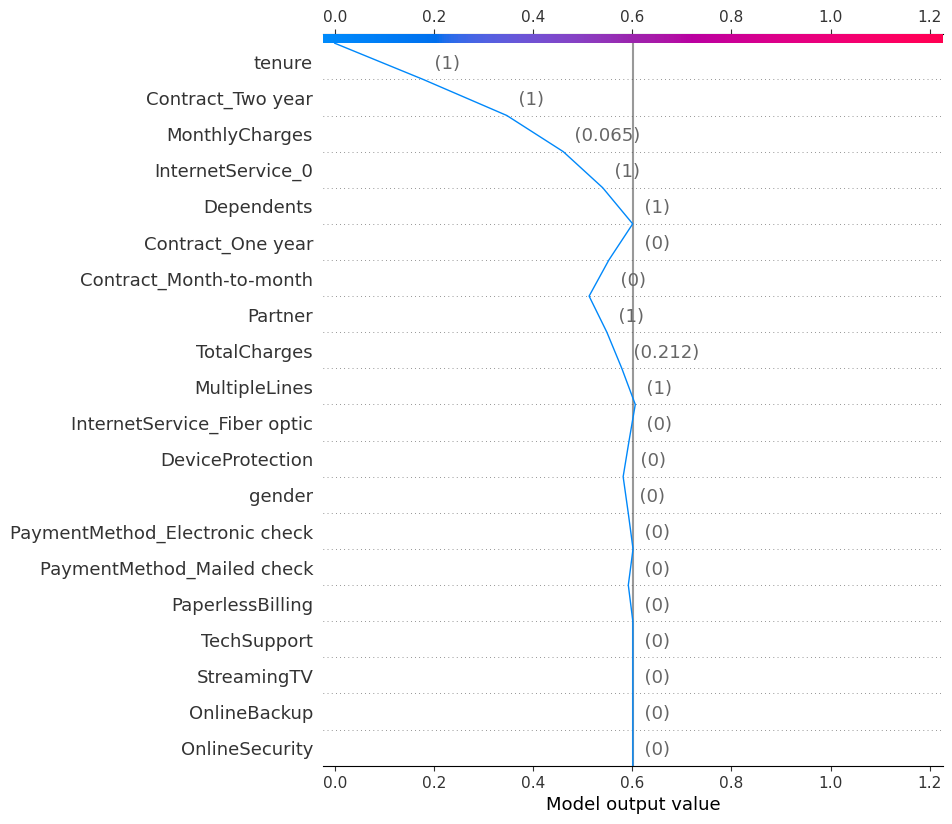

In [32]:
# SHAP local interpretation of data instance
shap.decision_plot(shap_explainer.expected_value, shap_values[idx], X_test.iloc[idx])

In [33]:
import alibi
from alibi.explainers import AnchorTabular

# initialise Anchor explainer
anchor_explainer = AnchorTabular(model.predict, data.columns.values)
anchor_explainer.fit(np.array(X_resample), disc_perc=[25, 50, 75])

# Anchor interpretation of data instance
anchor_exp = anchor_explainer.explain(X_test.values[idx], threshold=0.95)

print("Prediction: %s" % model.predict(X_test.values[idx].reshape(1,-1))[0])
print("Anchor: %s " % ("\n        ".join(anchor_exp.anchor)))
print("Precision  : %.2f" % anchor_exp['precision'])
print("Coverage   : %.2f" % anchor_exp['coverage'])

Prediction: 0
Anchor: tenure > 0.66
        InternetService_0 > 0.00 
Precision  : 0.98
Coverage   : 0.04


In [34]:
import eli5

# ELI5
eli5.show_prediction(model, X_test.iloc[idx], feature_names=data.columns.values, show_feature_values=True)